Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

In [3]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 4320
learning_rate = 0.0001

In [4]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[   0.,  143.,    0., ...,  130.,   64.,   98.],
       [ 306.,  286.,   12., ...,  712., 1260.,  338.],
       [   0.,    0.,   21., ...,   55.,  373.,  454.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 4320)


In [5]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(17808, 4320)

(4453, 4320)

(17808,)

(4453,)


In [6]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(17808, 4320)

(4453, 4320)

(17808, 1)

(4453, 1)


In [7]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

print(X_train_scaled_res.shape)
print()
print(y_train_scaled_res.shape)
print()
print(X_test_scaled_res.shape)
print()
print(y_test_scaled_res.shape)

(17808, 4320, 1)

(17808, 1, 1)

(4453, 4320, 1)

(4453, 1, 1)


In [8]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='lecun_normal', activation='linear'))
    model.compile(optimizer = optimizer, 
                  loss = 'mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [9]:
train_data = X_train_scaled_res
train_targets = y_train_scaled_res
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['root_mean_squared_error']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_root_mean_squared_error']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
742/742 [==============================] - 3741s 5s/step - loss: 0.1669 - root_mean_squared_error: 0.4085 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3466
Epoch 2/4
742/742 [==============================] - 3759s 5s/step - loss: 0.1214 - root_mean_squared_error: 0.3483 - val_loss: 0.1184 - val_root_mean_squared_error: 0.3441
Epoch 3/4
742/742 [==============================] - 5912s 8s/step - loss: 0.1211 - root_mean_squared_error: 0.3480 - val_loss: 0.1184 - val_root_mean_squared_error: 0.3440
Epoch 4/4
742/742 [==============================] - 11887s 16s/step - loss: 0.1208 - root_mean_squared_error: 0.3475 - val_loss: 0.1182 - val_root_mean_squared_error: 0.3439
processing fold # 1
Epoch 1/4
742/742 [==============================] - 3611s 5s/step - loss: 0.1442 - root_mean_squared_error: 0.3793 - val_loss: 0.1188 - val_root_mean_squared_error: 0.3447
Epoch 2/4
742/742 [==============================] - 3660s 5s/step - loss: 0.1205 - root_mean

In [18]:
print(np.mean([0.1182,0.1198,0.1202]))

0.11939999999999999


Training and validation results of 24h segment LSTM MODEL

In [10]:
print("RMSE of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean RMSE of all folds:\n")
print(np.mean(all_scores))

RMSE of fold 1, 2 and 3:

[0.3438641130924225, 0.3445793688297272, 0.3466775417327881]

Mean RMSE of all folds:

0.34504034121831256


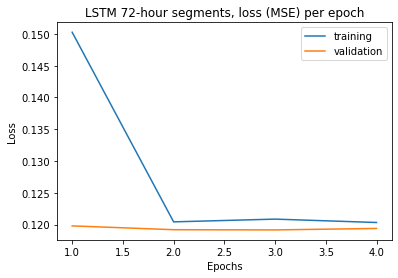

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 72-hour segments, RMSE per epoch')
plt.show()

Average per-epoch RMSE for all folds

In [20]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

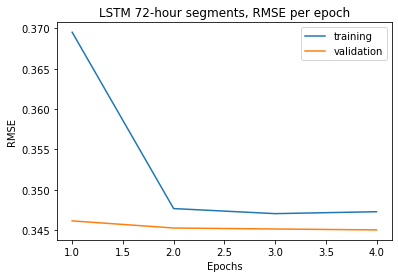

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 72-hour segments, RMSE per epoch')
plt.show()

In [28]:
print(average_mae_history)
print(val_average_mae_history)

[0.36952101190884906, 0.34768374760945636, 0.3470565875371297, 0.3472929497559865]
[0.34615954756736755, 0.3452763855457306, 0.34515459338823956, 0.34504032135009766]


Training final model on all of the training data and evaluate on test set

In [23]:
test_data = X_test_scaled_res 
test_targets = y_test_scaled_res

In [24]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history_test = model.fit(train_data, train_targets,
                        epochs=12, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/12
1113/1113 [==============================] - 5371s 5s/step - loss: 0.1402 - root_mean_squared_error: 0.3739
Epoch 2/12
1113/1113 [==============================] - 5483s 5s/step - loss: 0.1204 - root_mean_squared_error: 0.3469
Epoch 3/12
1113/1113 [==============================] - 7496s 7s/step - loss: 0.1190 - root_mean_squared_error: 0.3450
Epoch 4/12
1113/1113 [==============================] - 5268s 5s/step - loss: 0.1213 - root_mean_squared_error: 0.3482
Epoch 5/12
1113/1113 [==============================] - 5324s 5s/step - loss: 0.1204 - root_mean_squared_error: 0.3470
Epoch 6/12
1113/1113 [==============================] - 13970s 13s/step - loss: 0.1200 - root_mean_squared_error: 0.3464
Epoch 7/12
1113/1113 [==============================] - 5310s 5s/step - loss: 0.1197 - root_mean_squared_error: 0.3460
Epoch 8/12
1113/1113 [==============================] - 5291s 5s/step - loss: 0.1188 - root_mean_squared_error: 0.3447
Epoch 9/12
1113/1113 [========================

In [25]:
print("Average Mean Squared Error:\n")
print(test_mse_score)
print()
print("Average Root Mean Squared Error:\n")
print(test_mae_score)

Average Mean Squared Error:

0.12143051624298096

Average Root Mean Squared Error:

0.3484688103199005


In [26]:
model_predict = model.predict(X_test_scaled_res, verbose = 1)
model_predict = sc.inverse_transform(model_predict)
print(model_predict)
y_test_inversed = (sc.inverse_transform(y_test_scaled))

140/140 [==============================] - 112s 759ms/step
[[6.4305115]
 [6.710759 ]
 [6.7301846]
 ...
 [6.63189  ]
 [6.7061977]
 [6.7061977]]


In [27]:
y_actual = y_test_inversed
y_predicted = model_predict
 
MSE = mean_squared_error(y_actual, y_predicted)

#print(mean_absolute_error(y_actual, y_predicted))
print("Mean Squared Error:\n")
print(MSE)
print()
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:\n")
print(RMSE)

Mean Squared Error:

95.20154

Root Mean Squared Error:

9.757127553021817
